##### Image Segmentation for Disaster Resilience
### Project Overview
The Image Segmentation for Disaster Resilience system utilizes Machine Learning and Deep Learning to analyze satellite and drone imagery for detecting and assessing damage caused by natural disasters. This system aids in disaster response, resource allocation, and recovery planning by segmenting affected regions in real-time.

#### Importing Necessary Libraries

In [24]:
import os
import cv2
import numpy as np

# Base path to FloodNet Challenge -Track 1
base_path = "FloodNet Challenge - Track 1/Train/Labeled"

# Define paths for Flooded and Non-Flooded image and mask folders
flooded_image_dir = os.path.join(base_path, "Flooded/image")
flooded_mask_dir = os.path.join(base_path, "Flooded/mask")

non_flooded_image_dir = os.path.join(base_path, "Non-Flooded/image")
non_flooded_mask_dir = os.path.join(base_path, "Non-Flooded/mask")

# Output directory for patches
output_patch_dir = "FloodNet Challenge - Track 1/Patches"


In [25]:
base_path = "FloodNet Challenge - Track 1/Train/Labeled"
flooded_image_dir = os.path.join(base_path, "Flooded/image")
flooded_mask_dir = os.path.join(base_path, "Flooded/mask")
non_flooded_image_dir = os.path.join(base_path, "Non-Flooded/image")
non_flooded_mask_dir = os.path.join(base_path, "Non-Flooded/mask")
output_patch_dir = "FloodNet Challenge - Track 1/Patches"


In [26]:
import os
import cv2
import numpy as np

def create_patches(image_dir, mask_dir, output_dir, patch_size=512):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
    
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'masks'), exist_ok=True)

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        base_name = os.path.splitext(img_file)[0]
        img_height, img_width = img.shape[:2]

        for i in range(0, img_width, patch_size):
            for j in range(0, img_height, patch_size):
                if i + patch_size <= img_width and j + patch_size <= img_height:
                    img_patch = img[j:j + patch_size, i:i + patch_size]
                    mask_patch = mask[j:j + patch_size, i:i + patch_size]
                    cv2.imwrite(os.path.join(output_dir, 'images', f"{base_name}_{i}_{j}.jpg"), img_patch)
                    cv2.imwrite(os.path.join(output_dir, 'masks', f"{base_name}_{i}_{j}_lab.png"), mask_patch)

# Run patching on both sets
create_patches(flooded_image_dir, flooded_mask_dir, output_patch_dir)
create_patches(non_flooded_image_dir, non_flooded_mask_dir, output_patch_dir)


In [27]:
import matplotlib.pyplot as plt
import random

def display_random_patches(patch_dir, num_samples=3):
    image_dir = os.path.join(patch_dir, 'images')
    mask_dir = os.path.join(patch_dir, 'masks')

    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    for _ in range(num_samples):
        idx = random.randint(0, len(image_files) - 1)
        img_path = os.path.join(image_dir, image_files[idx])
        mask_path = os.path.join(mask_dir, mask_files[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Mask")
        plt.axis("off")

        plt.show()


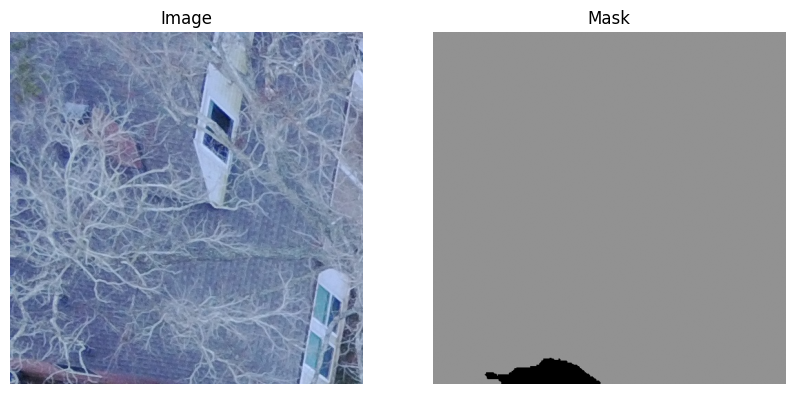

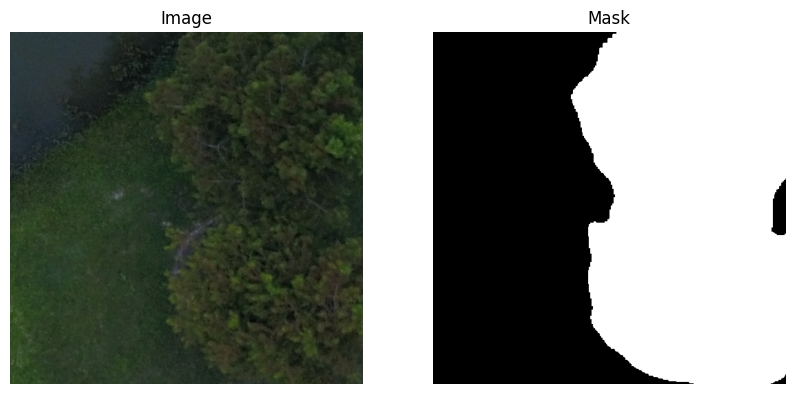

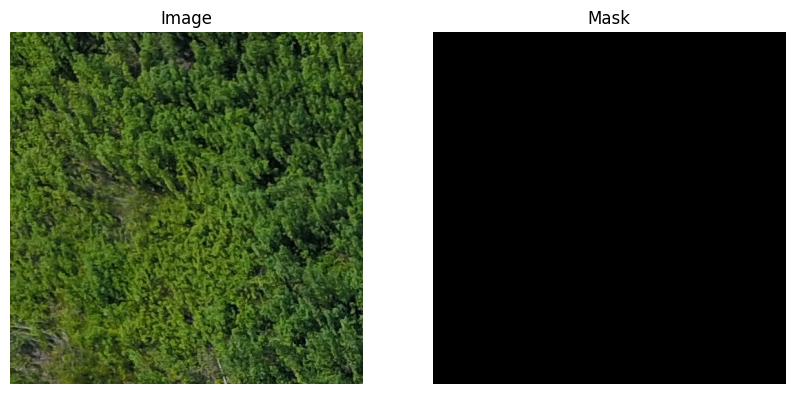

In [28]:
display_random_patches(output_patch_dir)


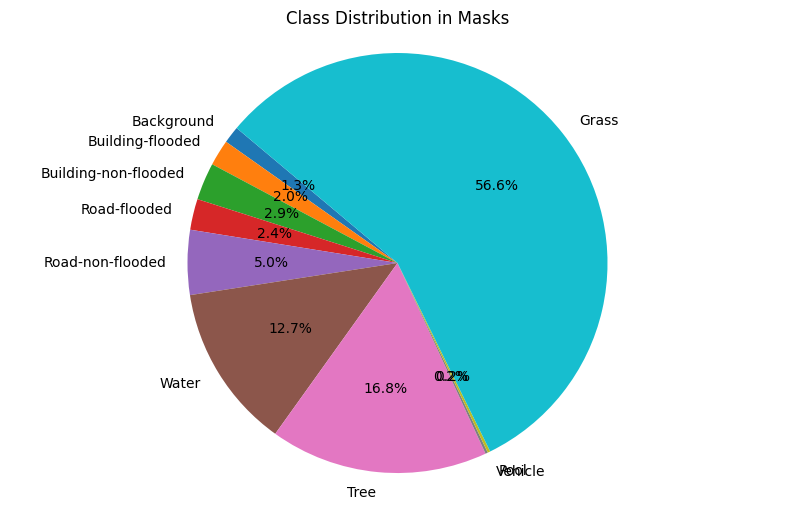

In [31]:
from PIL import Image

class_labels = {
    0: 'Background', 
    1: 'Building-flooded',
    2: 'Building-non-flooded',
    3: 'Road-flooded',
    4: 'Road-non-flooded',
    5: 'Water',
    6: 'Tree',
    7: 'Vehicle',
    8: 'Pool',
    9: 'Grass'
}
class_counts = {i: 0 for i in range(10)}
mask_dir = os.path.join(output_patch_dir, 'masks')

for filename in os.listdir(mask_dir):
    if filename.endswith('_lab.png'):
        mask = np.array(Image.open(os.path.join(mask_dir, filename)).convert('L'))
        for label in np.unique(mask):
            if label in class_counts:
                class_counts[label] += np.sum(mask == label)


lables = list(class_labels.values())
sizes = [class_counts[i] for i in range(10)]

plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=lables, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title("Class Distribution in Masks")
plt.axis("equal")
plt.show()

In [30]:
import shutil
random.seed(42)

all_files = [f for f in os.listdir(os.path.join(output_patch_dir, 'images')) if f.endswith('.jpg')]
random.shuffle(all_files)

train_split = int(0.6 * len(all_files))
val_split = int(0.2 * len(all_files))

splits = {
    'train': all_files[:train_split],
    'val': all_files[train_split:train_split + val_split],
    'test': all_files[train_split + val_split:]
}

for split in splits:
    for sub in ['images', 'masks']:
        os.makedirs(os.path.join('FloodNet Challenge - Track 1', split, sub), exist_ok=True)

    for file in splits[split]:
        mask_file = file.replace('.jpg', '_lab.png')

        shutil.copy(
            os.path.join(output_patch_dir, 'images', file),
            os.path.join('FloodNet Challenge - Track 1', split, 'images', file)
        )
        shutil.copy(
            os.path.join(output_patch_dir, 'masks', mask_file),
            os.path.join('FloodNet Challenge - Track 1', split, 'masks', mask_file)
        )
print("Dataset split completed.")   

Dataset split completed.
